In [1]:
# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random

import csv
from scipy import ndimage, misc
from tqdm import tqdm

In [15]:
# [STAR] Attribute and Category Model

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class MyAttrCateModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model    = models.resnet18(pretrained=True)
        self.model.fc = Identity()
        
        #self.attr_layer = nn.Sequential(nn.Linear(512, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 26, bias=False)
        #                               )
        
        #self.cate_layer = nn.Sequential(nn.Linear(512, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 50, bias=False))
        self.attr_layer = nn.Linear(512, 26)
        self.cate_layer = nn.Linear(512, 50)
    
    def forward(self, x):
        out1     = self.model(x)
        attr_out = self.attr_layer(out1)
        cate_out = self.cate_layer(out1)
        #cate_out = torch.flatten(cate_out)
        return attr_out, cate_out

class MyAttrCateModel50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model    = models.resnet50(pretrained=True)
        self.model.fc = Identity()
        
        #self.attr_layer = nn.Sequential(nn.Linear(2048, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 26, bias=False))
        #self.cate_layer = nn.Sequential(nn.Linear(2048, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 50, bias=False))
        self.attr_layer = nn.Linear(2048, 26)
        self.cate_layer = nn.Linear(2048, 50)
    
    def forward(self, x):
        out1     = self.model(x)
        attr_out = self.attr_layer(out1)
        cate_out = self.cate_layer(out1)
        #cate_out = torch.flatten(cate_out)
        return attr_out, cate_out
#model  = MyAttrCateModel()
# x      = torch.randn(1, 3, 224, 224)
# output = model(x)
# print(output[0].shape, output[1].shape)

#print(model)
#model_ft = model_ft.to(device)

In [32]:
# [STAR] Data Loaders for Fashion Dataset

from __future__ import division
import os

import numpy as np
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data.dataset import Dataset


class AttrDataset(Dataset):
    CLASSES = None
    
    def __init__(self,
                 img_path,
                 img_file,
                 label_file,
                 cate_file,
                 bbox_file,
                 landmark_file,
                 img_size,
                 idx2id=None):
        self.img_path = img_path

        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

        # read img names
        fp = open(img_file, 'r')
        self.img_list = [x.strip() for x in fp]

        # read attribute labels and category annotations
        self.labels = np.loadtxt(label_file, dtype=np.float32)

        # read categories
        self.categories = []
        catefn = open(cate_file).readlines()
        for i, line in enumerate(catefn):
            self.categories.append(line.strip('\n'))

        self.img_size = img_size
    
    def get_basic_item(self, idx):
        print(os.path.join(self.img_path, self.img_list[idx]))
        img = Image.open(os.path.join(self.img_path,
                                      self.img_list[idx])).convert('RGB')

        width, height  = img.size
        print('Original Image size is ', width, height)
        # Very Important
        # For getting the cropped and resized region of interest image
        img.thumbnail(self.img_size, Image.ANTIALIAS)
        img   = self.transform(img)

        label    = torch.from_numpy(self.labels[idx])
        cate     = torch.LongTensor([int(self.categories[idx]) - 1])

        data = {'img': img, 'attr': label, 'cate': cate}
        return data

    def __getitem__(self, idx):
        return self.get_basic_item(idx)

    def __len__(self):
        return len(self.img_list)
    
img_path   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/"
img_file   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train.txt"
label_file = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_attr.txt"
cate_file  = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_cate.txt"
img_size   = [224, 224]
#img_size   = [256, 256]

landmark_file = None
bbox_file     = None

d1 = AttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

img_file   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/val.txt"
label_file = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/val_attr.txt"
cate_file  = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/val_cate.txt"

d2 = AttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

from torch.utils.data import DataLoader


def build_dataloader(dataset, batch_size, shuffle):
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=1,
        pin_memory=False)
    return data_loader

train_data_loader = build_dataloader(d1, 4, True)
val_data_loader   = build_dataloader(d2, 4, False)

model  = MyAttrCateModel50()
#model  = MyAttrCateModel()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
lr_scheduler = None


In [17]:
# [STAR] For loading the labels and categories etc.

attr_list = []
attr_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_attr_cloth.txt").read().split('\n')
for t in attr_list_file[2:-1]:
    attr_list.append(t.split()[0])
attr_list = np.array(attr_list)

cate_list = []
cate_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_category_cloth.txt").read().split('\n')
for t in cate_list_file[2:-1]:
    cate_list.append(t.split()[0])
cate_list = np.array(cate_list)

print(cate_list)

['Anorak' 'Blazer' 'Blouse' 'Bomber' 'Button-Down' 'Cardigan' 'Flannel'
 'Halter' 'Henley' 'Hoodie' 'Jacket' 'Jersey' 'Parka' 'Peacoat' 'Poncho'
 'Sweater' 'Tank' 'Tee' 'Top' 'Turtleneck' 'Capris' 'Chinos' 'Culottes'
 'Cutoffs' 'Gauchos' 'Jeans' 'Jeggings' 'Jodhpurs' 'Joggers' 'Leggings'
 'Sarong' 'Shorts' 'Skirt' 'Sweatpants' 'Sweatshorts' 'Trunks' 'Caftan'
 'Cape' 'Coat' 'Coverup' 'Dress' 'Jumpsuit' 'Kaftan' 'Kimono' 'Nightdress'
 'Onesie' 'Robe' 'Romper' 'Shirtdress' 'Sundress']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/img/Draped_Longline_Cardigan/img_00000057.jpg
Original Image size is  236 300
['Cardigan']
['solid' 'long_sleeve' 'no_dress' 'no_neckline' 'cotton' 'conventional']
(224, 224, 3)


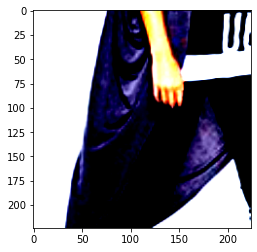

In [21]:
index = random.randint(0, len(d2))
temp  = d2[index]
#print(temp['cate'])

attr_index = np.nonzero(temp['attr'].data.numpy())[0]#temp['attr'].data.numpy().astype('int')
cate_index = temp['cate'].data.numpy()
#print(attr_index)
#print(cate_index)
#.astype('int')

temp = temp['img'].data.numpy()
#print(temp.shape)
temp = np.moveaxis(temp, 0, -1)
#print(temp.shape)

plt.imshow(temp)
#print(attr_index)
#print(cate_index)

print(cate_list[cate_index])
print(attr_list[attr_index])

print(temp.shape)

In [ ]:
# [STAR] MMFASHION Training Loop

loss_hist1  = Averager()
loss_hist2  = Averager()
loss_hist3  = Averager()


ce_loss  = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss()

batch_size = 4
counter    = 0
model.train()
prev_min = 1000

for epoch in range(100):
    for t1 in train_data_loader:
        new_images  = torch.Tensor(t1['img']).to(device)
        attr_target = t1['attr'].to(device)
        cate_target = t1['cate'].to(device)

        out1, out2  = model(new_images)
        cate_target = torch.reshape(cate_target, [batch_size])
        #print(out1.shape, out2.shape, cate_target.shape, attr_target.shape)

        loss1      = 5*bce_loss(out1, attr_target)
        loss2      = ce_loss(out2,  cate_target)

        losses     = loss1 + loss2 #sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        counter =  counter+1
    
    with torch.no_grad():
        for t1 in val_data_loader:
            new_images  = torch.Tensor(t1['img']).to(device)
            attr_target = t1['attr'].to(device)
            cate_target = t1['cate'].to(device)

            out1, out2  = model(new_images)
            cate_target = torch.reshape(cate_target, [batch_size])
            #print(out1.shape, out2.shape, cate_target.shape, attr_target.shape)

            loss1      = bce_loss(out1, attr_target)
            loss2      = ce_loss(out2,  cate_target)

            losses     = loss1 + loss2

            loss_hist1.send(loss1.data.item())
            loss_hist2.send(loss2.data.item())
            loss_hist3.send(losses.data.item())
    
    if loss_hist3.value < prev_min:
        print('Saving the model ', prev_min, loss_hist3.value)
        torch.save(model.state_dict(), 'fashion_cate_attr_resnet50_single_linear_equalweight.pth')
        prev_min = loss_hist3.value
    
    print('Epoch >> ', epoch, loss_hist3.value, loss_hist1.value, loss_hist2.value)

#a = next(dloader)
#print(a.keys())

Saving the model  1000 2.4690650403499603
Epoch >>  0 2.4690650403499603 0.32421635499596596 2.1448486886024476
Saving the model  2.4690650403499603 2.373939606845379
Epoch >>  1 2.373939606845379 0.31374691185355186 2.0601926976144314
Saving the model  2.373939606845379 2.3202684246699015
Epoch >>  2 2.3202684246699015 0.30673006669680275 2.0135383597215015
Saving the model  2.3202684246699015 2.2755222101211547
Epoch >>  3 2.2755222101211547 0.30178153750672937 1.973740673787892
Saving the model  2.2755222101211547 2.2398026696681974
Epoch >>  4 2.2398026696681974 0.29681208066642284 1.9429905903697013
Saving the model  2.2398026696681974 2.2018027129968005
Epoch >>  5 2.2018027129968005 0.29308239939560493 1.9087203140258788
Saving the model  2.2018027129968005 2.1711222874947955
Epoch >>  6 2.1711222874947955 0.28941710267961024 1.8817051849365234
Saving the model  2.1711222874947955 2.153285289078951
Epoch >>  7 2.153285289078951 0.2868471268117428 1.8664381622076034
Saving the mo

In [38]:
# [STAR] MMFASHION Testing on a single image

attr_list = []
attr_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_attr_cloth.txt").read().split('\n')
for t in attr_list_file[2:-1]:
    attr_list.append(t.split()[0])
attr_list = np.array(attr_list)

cate_list = []
cate_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_category_cloth.txt").read().split('\n')
for t in cate_list_file[2:-1]:
    cate_list.append(t.split()[0])
cate_list = np.array(cate_list)

model.load_state_dict(torch.load('fashion_cate_attr_resnet50_single_linear.pth'))
model.eval()

index = random.randint(0, len(d2))
t1    = d2[index]

new_images  = torch.Tensor(np.expand_dims(t1['img'], 0)).to(device)
attr_target = t1['attr'].to(device)
cate_target = t1['cate'].to(device)
        
out1, out2  = model(new_images)
        
out1 = torch.sigmoid(out1)
out2 = torch.softmax(out2, axis=1)

out1 = out1.data.cpu().numpy().flatten()
out2 = out2.data.cpu().numpy().flatten()

out1[out1 < 0.5] = 0
out1 = np.array(out1.flatten())

attr_index         = np.array(np.nonzero(out1))
attr_ground_index  = np.array(np.nonzero(t1['attr']).flatten())

cate_index         = np.argmax(out2)
cate_ground_index  = t1['cate'].data.cpu().numpy()#[0][0]

print(cate_index, cate_ground_index)
print("Predicted:    ", cate_list[cate_index], attr_list[attr_index])
print("Ground Truth: ", cate_list[cate_ground_index], attr_list[attr_ground_index])
        

/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/img/Embroidered_Woven_Dress/img_00000015.jpg
Original Image size is  200 300
40 [40]
Predicted:     Dress [['solid' 'long_sleeve' 'mini_length' 'crew_neckline' 'cotton' 'loose']]
Ground Truth:  ['Dress'] ['solid' 'long_sleeve' 'mini_length' 'no_neckline' 'cotton' 'loose']


In [24]:
t1['attr']

tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1.])

In [157]:
# [STAR] MMFASHION VALIDATION LOOP

attr_list = []
attr_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_attr_cloth.txt").read().split('\n')
for t in attr_list_file[2:-1]:
    attr_list.append(t.split()[0])
attr_list = np.array(attr_list)

cate_list = []
cate_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_category_cloth.txt").read().split('\n')
for t in cate_list_file[2:-1]:
    cate_list.append(t.split()[0])
cate_list = np.array(cate_list)

model.load_state_dict(torch.load('fashion_cate_attr_resnet50_single_linear.pth'))

loss_hist1  = Averager()
loss_hist2  = Averager()
loss_hist3  = Averager()


ce_loss  = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss()

batch_size = 4
counter    = 0
prev_min = 1000

val_data_loader   = build_dataloader(d2, 1, False)

model.eval()

with torch.no_grad():
    for t1 in val_data_loader:
        new_images  = torch.Tensor(t1['img']).to(device)
        attr_target = t1['attr'].to(device)
        cate_target = t1['cate'].to(device)
        
        #print(t1['attr'])
        #print(t1['cate'])
        
        out1, out2  = model(new_images)
        
        out1 = torch.sigmoid(out1)
        out2 = torch.softmax(out2, axis=1)
        
        out1 = out1.data.cpu().numpy().flatten()
        out2 = out2.data.cpu().numpy().flatten()
        
        out1[out1 < 0.5] = 0
        out1 = np.array(out1.flatten())
        
        attr_index         = np.array(np.nonzero(out1)[0])
        attr_ground_index  = np.array(np.nonzero(t1['attr'][0]).flatten())
        
        cate_index         = np.argmax(out2)
        cate_ground_index  = t1['cate'].data.cpu().numpy()[0][0]
        
        print(cate_index, cate_ground_index)
        print("Predicted:    ", cate_list[cate_index], attr_list[attr_index])
        print("Ground Truth: ", cate_list[cate_ground_index], attr_list[attr_ground_index])
        print('---------------------')

16 2
Predicted:     Tank ['long_sleeve' 'no_dress' 'cotton' 'conventional']
Ground Truth:  Blouse ['graphic' 'long_sleeve' 'no_dress' 'crew_neckline' 'cotton'
 'conventional']
---------------------
31 17
Predicted:     Shorts ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'tight']
Ground Truth:  Tee ['solid' 'sleeveless' 'no_dress' 'crew_neckline' 'cotton' 'tight']
---------------------
40 32
Predicted:     Dress ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
Ground Truth:  Skirt ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'denim' 'conventional']
---------------------
10 1
Predicted:     Jacket ['solid' 'long_sleeve' 'no_dress' 'v_neckline' 'cotton' 'conventional']
Ground Truth:  Blazer ['solid' 'long_sleeve' 'no_dress' 'v_neckline' 'cotton' 'conventional']
---------------------
1 10
Predicted:     Blazer ['solid' 'long_sleeve' 'no_dress' 'v_neckline' 'cotton' 'conventional']
Ground Truth:  Jacket ['solid' 'long_sleeve' 'no_dress' 'v_neckline' 'cott

KeyboardInterrupt: 

In [ ]:
img_list_path   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train.txt"

train_cate_path = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_cate.txt"
train_attr_path = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_attr.txt"


img_list = open(img_list_path).read()
img_list = img_list.split("\n")[:-1]

print(len(img_list))
basepath = ""

for i in tqdm(range(len(img_list))):
    #print(img_list[i])
    img_path = basepath+"/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/"+img_list[i]
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    #print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    print(image.shape)

In [23]:
import random

img_list_path   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train.txt"

img_list = open(img_list_path).read()
img_list = img_list.split("\n")[:-1]

#print(img_list)
index = random.randint(0, 10000)
print(index, img_list[index])

6197 img/Wifey_Graphic_Muscle_Tee/img_00000018.jpg
